# 1. Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Set the style globally
# Alternatives include bmh, fivethirtyeight, ggplot,
# dark_background, seaborn-deep, etc
plt.style.use('seaborn-white')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['figure.figsize'] = 8, 6

np.random.seed(0)

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.externals import joblib

# 2. Load cleaned data

In [5]:
data = pd.read_csv('data/clean_titanic.csv')

### Spilit into training, validation and test set

we will split our data set into the following parts: (60% - train set, 20% - validation set, 20% - test set):

In [6]:
train, validate, test = np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])

In [8]:
feature = ['pclass',  'sex', 'age','fare']
X_train = train[feature]
y_train = train.survived
X_val   = validate[feature]
y_val   = validate.survived

# 3. Hyper-parameter Selection

We will be using Grid search to find best hyper-parameters of the model.

## 3.1 Grid search with Cross-validation

## 3. 2.1 GridSearchCV
[Sklearn](scikit-learn.org) has implemented a grid search class (GridSearchCV) which simply the whole procedure. To use this class:

In [7]:
from sklearn.model_selection import GridSearchCV

In [8]:
score='f1'
parameter = {"max_depth": [3, None],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
skfold = model_selection.StratifiedKFold(n_splits=10)
rForest =  RandomForestClassifier()
gridCV = GridSearchCV(rForest, param_grid=parameter, scoring=score, cv=skfold)
gridCV.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, None], 'min_samples_split': [2, 3, 10], 'min_samples_leaf': [1, 3, 10], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [9]:
print("Validation best score: %.2f" %gridCV.score(X_val,y_val))
print("Training best score: %.2f" %gridCV.best_score_)
print("Best parameter: {}" .format(gridCV.best_params_))

Validation best score: 0.63
Training best score: 0.73
Best parameter: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}


Grid search is only suitable when you have few hyperparameter search space. Let us explore other type of grid search with Random grid search.

## 3.2.2 RandomizedSearchCV
RandomizedSearchCV is the best when the hyperparameter search space is large. Unlike GridSearchCV, RandomizedSearchCV evaluate a given number of random combination by selection random value for each hyperparameter.

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# specify parameters and distributions to sample from
parameter = {"max_depth": [3, None],
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

score='f1'
skfold = model_selection.StratifiedKFold(n_splits=10)
rForest =  RandomForestClassifier()
gridRandom = RandomizedSearchCV(rForest, parameter, scoring=score, cv=skfold, n_iter=5)
gridRandom.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
          error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'max_depth': [3, None], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc70e577860>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc70e631cc0>, 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          retur

In [12]:
print("Validation best score: %.2f" %gridRandom.score(X_val,y_val))
print("Training best score: %.2f" %gridRandom.best_score_)
print("Best parameter: {}" .format(gridRandom.best_params_))

Validation best score: 0.62
Training best score: 0.71
Best parameter: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}


We will use RandomizedSearchCV to select best hyperparameters of the selected models (KNN and Random Forest)

# 4. Train the tuned model with best parameter and [save trained model](https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/) on disk




In [14]:
train_new = pd.concat([train, validate])

In [15]:
X_train_new = train_new[feature]
y_train_new = train_new.survived
X_test = test[feature]
y_test = test.survived

In [38]:
def build_classifiers(X_train, y_train, X_test, y_test, score='f1'):
    rforest =  RandomForestClassifier()
    rforest_tuned =  RandomForestClassifier(criterion='gini', max_depth=None,
                                            min_samples_leaf=6, min_samples_split=10,bootstrap=False)
    model_names = ["RForest_old","RForest_tuned"]
    models = [rforest, rforest_tuned]
    
    avg_results = []
    f_score_test = []
   
    for (i,model) in enumerate(models):
      
        skfold = model_selection.StratifiedKFold(n_splits=10)
        cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=skfold, scoring=score)
        avg_results.append(cv_results.mean())
        msg = "%s: %f" % (model_names[i], cv_results.mean())
        print(msg)
        
        model.fit(X_train, y_train)
        y_p= model.predict(X_test)
        f_score_test.append(f1_score(y_test, y_p))
        filename = 'model/%s.sav' %(model_names[i])
        joblib.dump(model, filename)
        
    return avg_results, model_names, f_score_test  

In [39]:
result, names, test_score  = build_classifiers(X_train,y_train,X_test, y_test, score='f1')

RForest_old: 0.695924
RForest_tuned: 0.713520


In [40]:
def plotbar(plot_name, names, result,title,ylabel):
    postion = np.arange(len(names))
    plt.bar(postion, result, align='center', color ='g')
    plt.xticks(postion, names, rotation=90)
    plt.ylabel(ylabel)
    plt.ylim(0,1)
    plt.title(title)
    #plt.savefig('image/%s.pdf' %(plot_name), format='pdf')

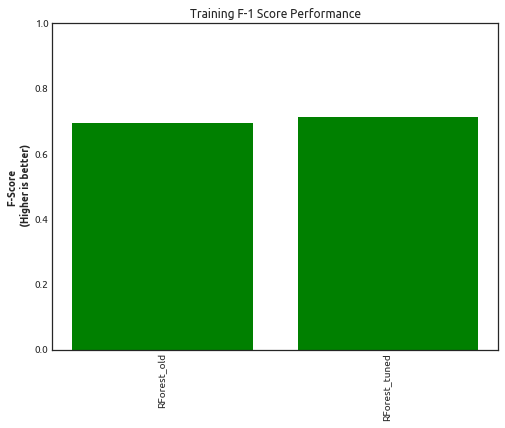

In [41]:
plotbar("_perfomance_training", names, result, "Training F-1 Score Performance", "F-Score \n (Higher is better)")

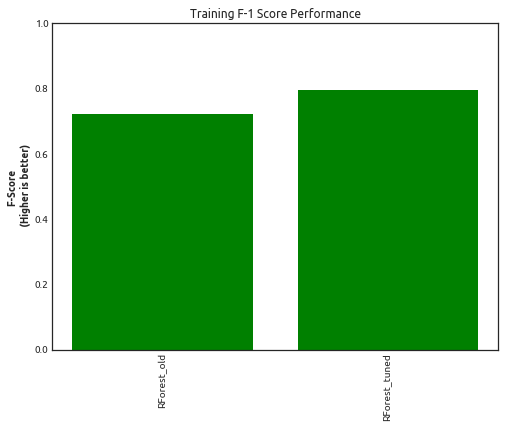

In [42]:
plotbar("_perfomance_test", names, test_score, "Training F-1 Score Performance", "F-Score \n (Higher is better)")

In [9]:
X = test[feature].iloc[1]

## 6. Demo

In [ ]:
rforest = joblib.load('model/RForest_tuned.sav')
while True:
    row = input('Enter row number or type exit to quit \t:')
    if row == "exit":
        print("Goodbye that is how ML works")
        break
    elif int(row) > len(test):
        print("Check the number of rows and type again")
        
    else:
        i=int(row)
        X = test[feature].iloc[i]
        print("I am using the following features to predict: {}".format(X))
        y = test.survived.iloc[i]
        X = X[:, np.newaxis]
        y_p = rforest.predict(X.T)
        print("Predicted label: {}".format(y_p[0]))
        print("The true label:  {}".format(y))
        if y== y_p:
            print("Perfect ML is cool")
        else:
            print("ML sometimes fails")
        
        

Enter row number or type exit to quit 	:0
I am using the following features to predict: pclass     1.0000
sex        0.0000
age       44.0000
fare      57.9792
Name: 160, dtype: float64
Predicted label: 1
The true label:  1
Perfect ML is cool
Enter row number or type exit to quit 	:45678999
Check the number of rows and type again
